In [2]:
import pandas as pd
from definitions import RESULTS_DIR
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Nicer log names
mapping = {
    'BPI_Challenge_2013_closed_problems.xes.gz': 'BPIC 2013 closed problems',
    'BPI_Challenge_2012.xes.gz': 'BPIC 2012',
    'BPI_Challenge_2013_incidents.xes.gz': 'BPIC 2013 incidents',
    'BPI_Challenge_2013_open_problems.xes.gz': 'BPIC 2013 open problems',
    'BPI%20Challenge%202017.xes.gz': 'BPIC 2017',
    'BPIC15_1.xes': 'BPIC 2015',
    'Road_Traffic_Fine_Management_Process.xes.gz': 'RTFMP',
    'Sepsis%20Cases%20-%20Event%20Log.xes.gz': 'Sepsis',
    'helpdesk.csv': 'Helpdesk',
    'RTFMP_filtered.xes': 'RTFMP filtered',
}

# Training

In [37]:
all_training_results = pd.read_csv('all_training_results.csv')
all_training_results['log'] = all_training_results['log'].map(mapping)
all_training_results['freezed_layers'] = all_training_results['freezed_layers'].fillna('None')
all_training_results

,Unnamed: 0,datetime,epoch,training_loss_activity,training_loss_time,training_loss,validation_loss_activity,validation_loss_time,validation_loss,elapsed_seconds,log,architecture,setting,freezed_layers
0,0,202312090718,0,1.9248,0.0013,1.9260,1.8914,0.0011,1.8925,0.565,BPIC 2013 closed problems,rnn,base,None
1,1,202312090718,1,1.8428,0.0014,1.8442,1.7063,0.0020,1.7083,0.212,BPIC 2013 closed problems,rnn,base,None
2,2,202312090718,2,1.6531,0.0018,1.6549,1.5158,0.0012,1.5170,0.208,BPIC 2013 closed problems,rnn,base,None
3,3,202312090718,3,1.5426,0.0020,1.5446,1.4599,0.0012,1.4611,0.205,BPIC 2013 closed problems,rnn,base,None
4,4,202312090718,4,1.5979,0.0016,1.5995,1.4324,0.0010,1.4335,0.210,BPIC 2013 closed problems,rnn,base,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39498,39498,202312171427,195,0.6147,0.0042,0.6188,0.1525,0.0032,0.1557,3.698,Helpdesk,GPT,RTFMP,['0']
39499,39499,202312171427,196,0.6054,0.0041,0.6095,0.1525,0.0032,0.1557,3.699,Helpdesk,GPT,RTFMP,['0']
39500,39500,202312171427,197,0.6082,0.0041,0.6123,0.1523,0.0032,0.1555,3.664,Helpdesk,GPT,RTFMP,['0']
39501,39501,202312171427,198,0.6092,0.0041,0.6133,0.1521,0.0032,0.1553,3.671,Helpdesk,GPT,RTFMP,['0']


## Extraction of the training results
In the following we extract the training results from the training statistics files. The results are stored in a pandas DataFrame.
The available information included in the training statistics files is:
- `epoch`: The epoch number
- `elapsed_seconds`: The time in seconds training took for this epoch
- `training_loss_activity`: The training loss for the activity prediction
- `training_loss_time`: The training loss for the time prediction
- `training_loss`: The training loss for the combined activity and time prediction
- `validation_loss_activity`: The validation loss for the activity prediction
- `validation_loss_time`: The validation loss for the time prediction
- `validation_loss`: The validation loss for the combined activity and time prediction

We extract the following information from the training statistics files:
- `mean_elapsed_seconds`: The mean time in seconds training took for one epoch
- `total_elapsed_seconds`: The total time in seconds training took for all epochs
- `number_of_epochs`: The number of epochs that have been trained (interesting for the early stopping)
- `final_validation_loss_activity`: The final validation loss for the activity prediction
- `final_validation_loss_time`: The final validation loss for the time prediction
- `final_validation_loss`: The final validation loss for the combined activity and time prediction

We also store the log, architecture and setting (base, RTFMP or helpdesk) and the freezed layers (only for the pre-trained models) in the DataFrame.

In [38]:
training_results_df = all_training_results.groupby(['log', 'architecture', 'setting', 'freezed_layers'], dropna=False)\
    .agg(
        mean_elapsed_seconds=('elapsed_seconds', 'mean'),
        total_elapsed_seconds=('elapsed_seconds', 'sum'),
        number_of_epochs=('epoch', lambda x: x.max() + 1),
        final_validation_loss=('validation_loss', 'last'),
        final_validation_loss_activity=('validation_loss_activity', 'last'),
        final_validation_loss_time=('validation_loss_time', 'last')
    ).reset_index()
training_results_df['freezed_layers_count'] = training_results_df['freezed_layers'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# compute the fraction of the training time based on the base model
training_results_df['fraction_of_total_base_training_time'] = training_results_df\
    .apply(lambda row: row['total_elapsed_seconds'] / 
                       training_results_df[(training_results_df['log'] == row['log']) & 
                                           (training_results_df['architecture'] == row['architecture']) & 
                                           (training_results_df['setting'] == 'base')]['total_elapsed_seconds'].iloc[0], axis=1)
training_results_df['fraction_of_mean_base_training_time'] = training_results_df\
    .apply(lambda row: row['mean_elapsed_seconds'] / 
                       training_results_df[(training_results_df['log'] == row['log']) & 
                                           (training_results_df['architecture'] == row['architecture']) & 
                                           (training_results_df['setting'] == 'base')]['mean_elapsed_seconds'].iloc[0], axis=1)

training_results_df

,log,architecture,setting,freezed_layers,mean_elapsed_seconds,total_elapsed_seconds,number_of_epochs,final_validation_loss,final_validation_loss_activity,final_validation_loss_time,freezed_layers_count,fraction_of_total_base_training_time,fraction_of_mean_base_training_time
0,BPIC 2012,GPT,base,None,68.613580,27445.432,400,0.0543,0.0543,0.0000,1,1.000000,1.000000
1,BPIC 2012,rnn,RTFMP,"['0', '1', '2', '3']",14.920925,2984.185,200,0.4524,0.4522,0.0002,4,0.544927,0.915477
2,BPIC 2012,rnn,RTFMP,"['0', '1', '2']",14.831045,2966.209,200,0.4569,0.4567,0.0002,3,0.541644,0.909962
3,BPIC 2012,rnn,RTFMP,"['0', '1', '3']",14.810330,2962.066,200,0.4464,0.4462,0.0002,3,0.540888,0.908691
4,BPIC 2012,rnn,RTFMP,"['0', '1']",14.799995,2959.999,200,0.4509,0.4507,0.0002,2,0.540510,0.908057
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Sepsis,rnn,helpdesk,"['0', '1', '3']",2.301605,460.321,200,1.0631,1.0614,0.0017,3,0.950682,1.026736
193,Sepsis,rnn,helpdesk,"['0', '1']",2.299390,459.878,200,1.0615,1.0599,0.0016,2,0.949767,1.025748
194,Sepsis,rnn,helpdesk,"['0', '2', '3']",2.283911,438.511,192,1.1144,1.1129,0.0015,3,0.905638,1.018843
195,Sepsis,rnn,helpdesk,['0'],2.301600,460.320,200,1.1618,1.1603,0.0015,1,0.950680,1.026734


# Analysis of the training results

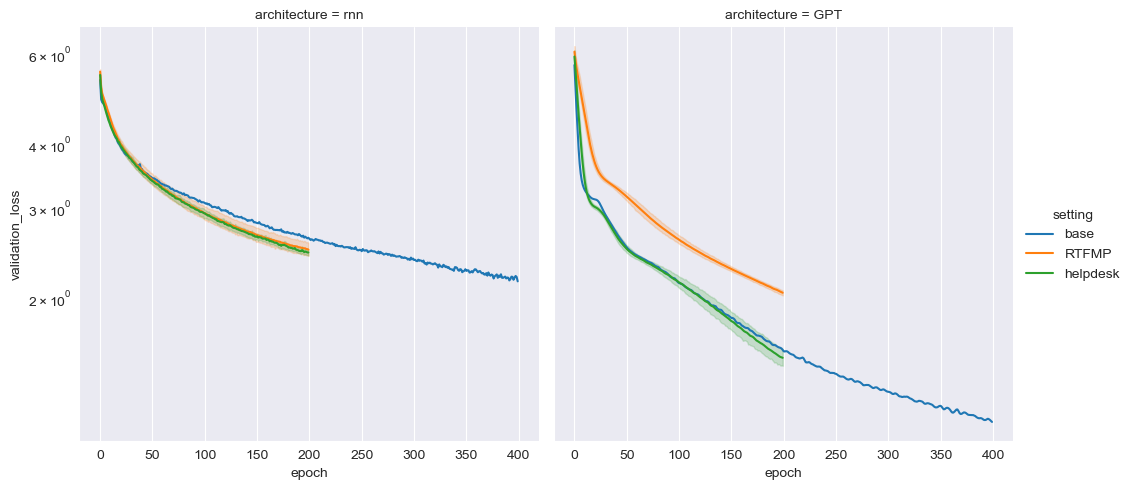

In [44]:
# Plot the validation loss based on the freezed layers for one log
g = sns.relplot(
    data=all_training_results[all_training_results['log'] == 'BPIC 2015'], 
    x='epoch', 
    y='validation_loss', 
    hue='setting',
    col='architecture',
    kind='line',
)
# Set the y axis to log scale
g.set(yscale='log')

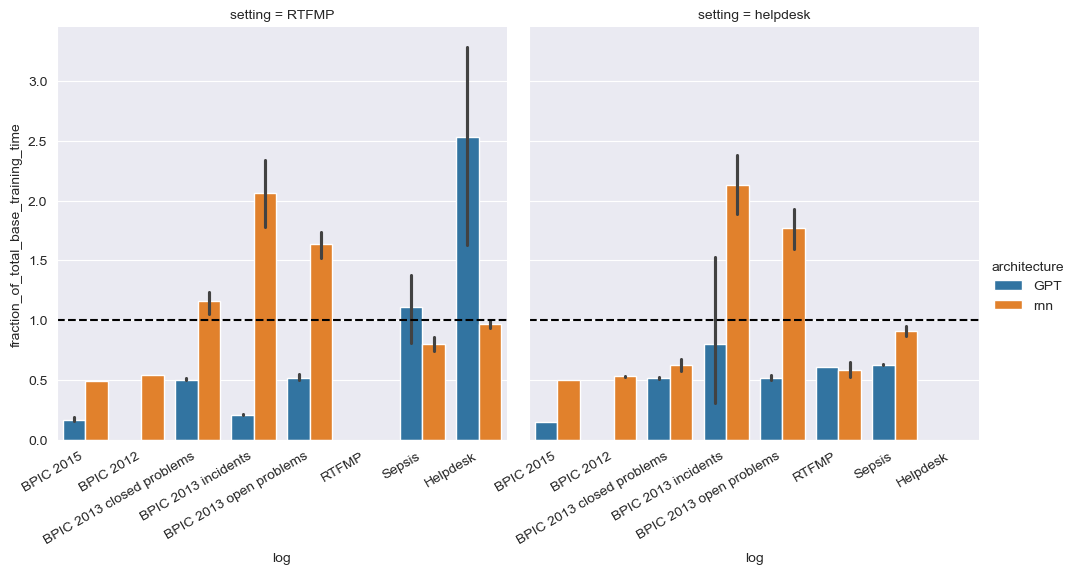

In [22]:
# Plot the fraction of the training time based on the base model
g = sns.catplot(data=training_results_df[training_results_df['setting'] != 'base'], x='log', y='fraction_of_total_base_training_time', hue='architecture', kind='bar', col='setting', col_wrap=2)
# Draw a line at 1 to indicate the base model
for ax in g.axes:
    ax.axhline(1, ls='--', color='black')
# Rotate the xticklabels
g.set_xticklabels(rotation=30, horizontalalignment='right')

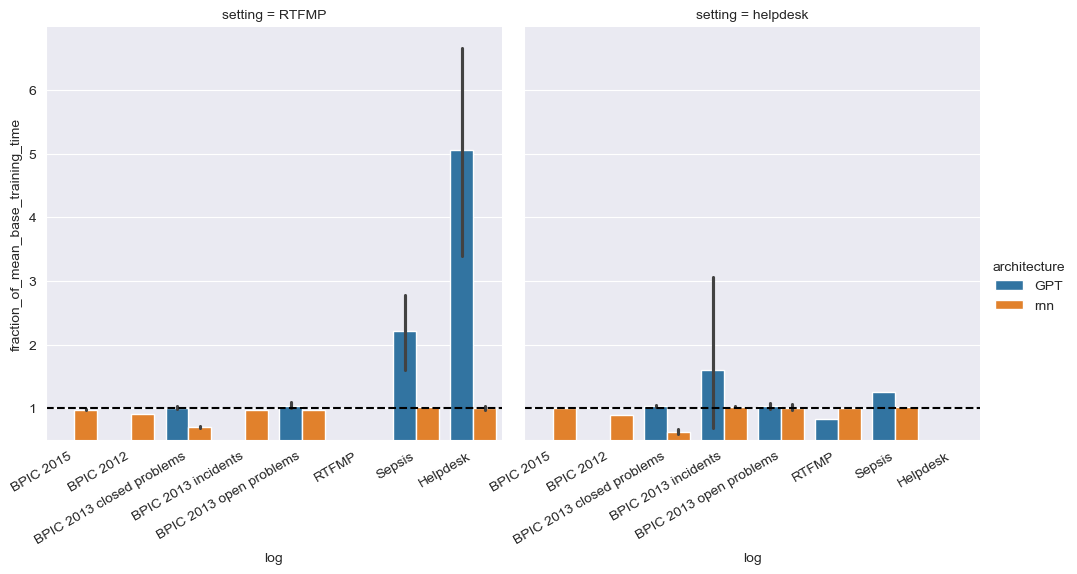

In [23]:
# Plot the fraction of the training time based on the base model
g = sns.catplot(data=training_results_df[training_results_df['setting'] != 'base'], x='log', y='fraction_of_mean_base_training_time', hue='architecture', kind='bar', col='setting', col_wrap=2)
# Draw a line at 1 to indicate the base model
for ax in g.axes:
    ax.axhline(1, ls='--', color='black')
# Rotate the xticklabels
g.set_xticklabels(rotation=30, horizontalalignment='right')
# Set y min to 0.5
g.set(ylim=(0.5, None))

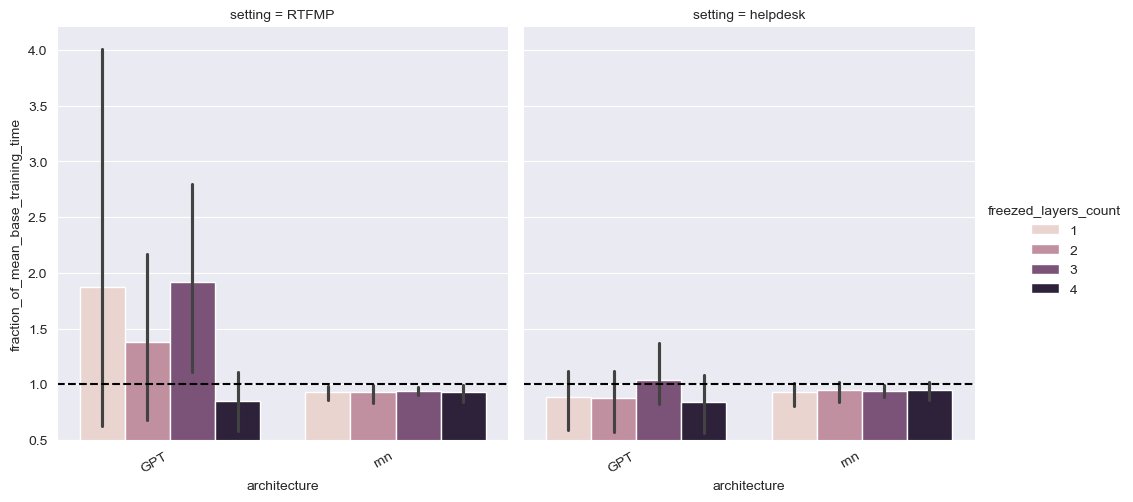

In [25]:
# Plot the fraction of the mean training time based on the count of freezed layers
g = sns.catplot(data=training_results_df[training_results_df['setting'] != 'base'], x='architecture', y='fraction_of_mean_base_training_time', hue='freezed_layers_count', kind='bar', col='setting', col_wrap=2)
# Draw a line at 1 to indicate the base model
for ax in g.axes:
    ax.axhline(1, ls='--', color='black')
# Rotate the xticklabels
g.set_xticklabels(rotation=30, horizontalalignment='right')
# Set y min to 0.5
g.set(ylim=(0.5, None))

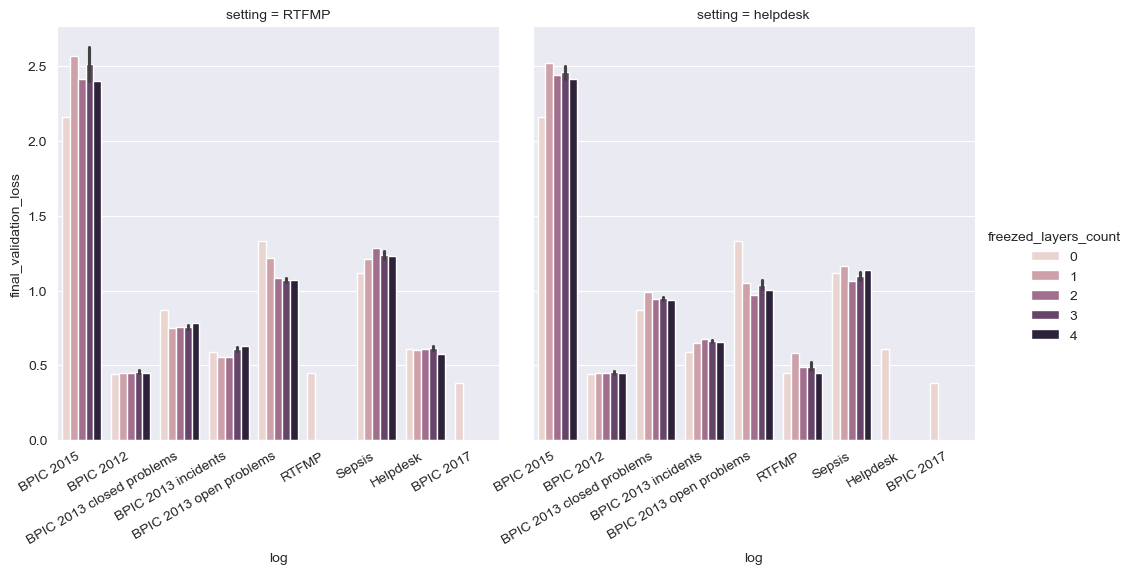

In [26]:
# Plot the fraction of the mean training time based on the count of freezed layers
# copy the dataframe and add a column with the log name without the count of freezed layers
data = training_results_df.copy()
# duplicate the base rows for each pre trained model
dfs = []
for pre_trained_setting in ['RTFMP', 'helpdesk']:
    base_rows = data[data['setting'] == 'base'].copy()
    base_rows['setting'] = pre_trained_setting
    base_rows['freezed_layers_count'] = 0
    dfs.append(base_rows)
data = pd.concat([data] + dfs)

g = sns.catplot(data=data[(data['setting'] != 'base') & (data['architecture'] == 'rnn')], x='log', y='final_validation_loss', hue='freezed_layers_count', kind='bar', col='setting', col_wrap=2)
# Rotate the xticklabels
g.set_xticklabels(rotation=30, horizontalalignment='right')

In [27]:
# compute the difference in the total epochs needed for training based on the base model
training_results_df['difference_in_total_epochs'] = training_results_df.apply(lambda row: row['number_of_epochs'] - training_results_df[(training_results_df['log'] == row['log']) & (training_results_df['architecture'] == row['architecture']) & (training_results_df['setting'] == 'base')]['number_of_epochs'].iloc[0], axis=1)
training_results_df

,log,architecture,setting,freezed_layers,mean_elapsed_seconds,total_elapsed_seconds,number_of_epochs,final_validation_loss,final_validation_loss_activity,final_validation_loss_time,freezed_layers_count,fraction_of_total_base_training_time,fraction_of_mean_base_training_time,difference_in_total_epochs
0,BPIC 2017,GPT,base,NaN,172.031065,68812.426,400,0.0767,0.0767,0.0001,0,1.000000,1.000000,0
1,BPIC 2017,rnn,base,NaN,187.931333,37774.198,201,0.3850,0.3848,0.0002,0,1.000000,1.000000,0
2,BPIC 2015,GPT,RTFMP,"['0', '1', '2', '3']",0.856870,171.374,200,2.0599,2.0594,0.0005,4,0.162486,0.324972,-200
3,BPIC 2015,GPT,RTFMP,"['0', '1', '2']",0.859595,171.919,200,2.0767,2.0760,0.0007,3,0.163003,0.326006,-200
4,BPIC 2015,GPT,RTFMP,"['0', '1', '3']",0.860090,172.018,200,2.0840,2.0833,0.0007,3,0.163097,0.326194,-200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Helpdesk,rnn,RTFMP,"['0', '1']",0.233195,46.639,200,0.6091,0.6038,0.0053,2,0.978577,1.012828,-7
193,Helpdesk,rnn,RTFMP,"['0', '2', '3']",0.233485,46.697,200,0.5973,0.5924,0.0049,3,0.979794,1.014087,-7
194,Helpdesk,rnn,RTFMP,['0'],0.216325,43.265,200,0.6026,0.5972,0.0054,1,0.907784,0.939557,-7
195,Helpdesk,rnn,RTFMP,"['1', '2', '3']",0.234670,46.934,200,0.6289,0.6241,0.0047,3,0.984767,1.019234,-7


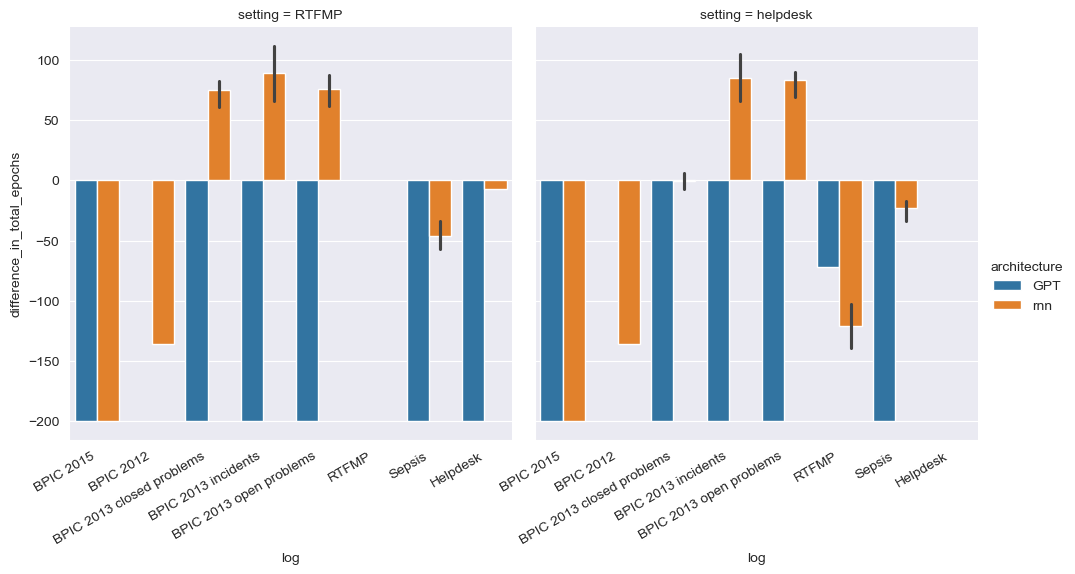

In [28]:
# Plot the difference in the total epochs needed for training based on the base model
g = sns.catplot(data=training_results_df[training_results_df['setting'] != 'base'], x='log', y='difference_in_total_epochs', hue='architecture', kind='bar', col='setting', col_wrap=2)
g.set_xticklabels(rotation=30, horizontalalignment='right')

# Evaluation

In [6]:
all_evaluation_results = pd.read_csv('all_evaluation_results.csv')
all_evaluation_results['log'] = all_evaluation_results['log'].map(mapping)
all_evaluation_results['freezed_layers'] = all_evaluation_results['freezed_layers'].fillna('None')
all_evaluation_results

,architecture,log,setting,freezed_layers,dls,mae,mae_denormalised,nb_worst_situs
0,rnn,BPIC 2017,base,None,0.0691,0.7416,100.9505,223449
1,rnn,BPIC 2017,RTFMP,"['0', '1', '2', '3']",0.0372,5.1177,696.6516,227572
2,rnn,BPIC 2015,base,None,0.0264,2.6185,2549.0971,9359
3,rnn,BPIC 2015,helpdesk,"['0', '1', '2', '3']",0.0226,2.4174,2353.3574,9307
4,rnn,BPIC 2015,helpdesk,"['0', '1', '2']",0.0323,1.8449,1795.9604,9226
...,...,...,...,...,...,...,...,...
130,rnn,Sepsis,RTFMP,"['0', '1']",0.2154,0.0794,33.1198,0
131,rnn,Sepsis,RTFMP,['0'],0.1153,4.9646,2071.5384,1884
132,rnn,Sepsis,RTFMP_filtered,"['0', '1', '2']",0.0734,5.8221,2429.3135,2527
133,rnn,Sepsis,RTFMP_filtered,['0'],0.0950,1.2984,541.7548,2647


In [ ]:
paper_results = pd.read_csv('paper_results.csv')